# Dealing with sparse proxy data over uncertain time

This notebook follows a discussion about dealing with uncertainty in age depth models. Given some proxy data collectd at a given depth, we want to express uncertainty in proxy value at absolute age steps. This is similar to the COPRA approach.


### Importing packages

In [2]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# import the JSON reader
try:
    import simplejson as json
except (ImportError,):
    import json

The Oxcal output was converted to JSON format.

For a file named 'output.js' (standard model output from Oxcal), several lines of JavaScript were added at the start and end. 

At the start:

```
var ocd = [];
var calib = [];
var model=[];

```

At the end:

```
const obj = {ocd, calib,model}

const fs = require('fs');
fs.writeFile("output.txt", JSON.stringify(obj), function(err) {
    if(err) {
        return console.log(err);
    }

    console.log("The file was saved!");
}); 
```

Finally, on the command line, the command `node output.js` was run. This produces a file called 'output.txt', which is easily loaded in python using``json.load()`

In [4]:
# open the Oxcal output age model
file = open("sample_data/Iglu_sequence_wo_outliers.txt",'r')

# read the json notated file
model = json.load(file)

`model` is now a set of incredibly nested dictionaries.

### Plotting the bog standard model output

(1000, 2000)

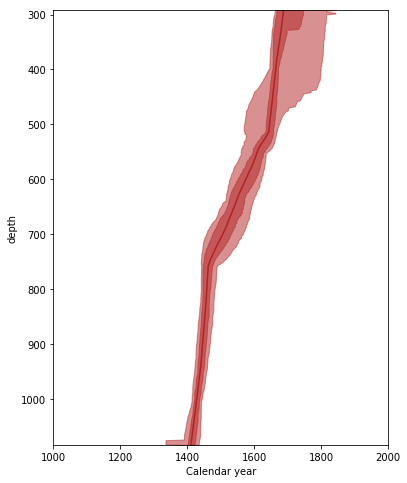

In [34]:
# collect the data of interest
data = np.array([(m['data']['z'],
                  m['posterior']['median'],           # the median age
                  m['posterior']['range'][1][0][0],   # the left bound of the first element in 'range' object 68%
                  m['posterior']['range'][1][-1][-2], # the right bound of the penultimate element in 'range' object
                  m['posterior']['range'][2][0][0],   # same but for 95.4% (2Ò)
                  m['posterior']['range'][2][-1][-2], # same but for 95.4% (2Ò)
                  m['posterior']['sigma']
                 ) 
                 for m in model['ocd'][21:]]          # list comprehension
               ).T                                    # transpose the array so each row is a variable

# plot the bog standard output
fig,ax = plt.subplots(figsize= (6,8))

# plot the median age as line
ax.plot(data[1],data[0],color = "firebrick")

# plot the 1Ò bounds as field
ax.fill_betweenx(x1=data[2],x2 = data[3],y =data[0],alpha=0.5,color = 'firebrick')

# plot the 2Ò bounds as field
ax.fill_betweenx(x1=data[4],x2 = data[5],y =data[0],alpha=0.5,color = 'firebrick')

# flip the graph so ages increase with depth
ax.set_ylim(max(data[0]),min(data[0]))

# tidy up axes
ax.set_ylabel("depth")
ax.set_xlabel("Calendar year")

ax.set_xlim(1000,2000)

This looks more or less exactly like the normal oxcal output graphs, but it still fails to capture the full probability density functions at each depth slice in the model. 

Let' see what the output actually looks like at a random depth, say 800.

Text(0.5,0,'Calendar year AD')

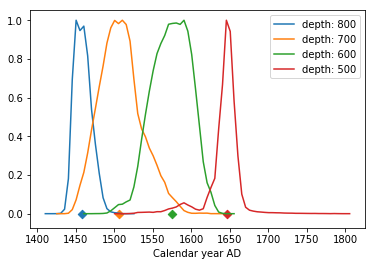

In [46]:
def plotPDF(z,ax):
    
    '''returns a plot artist of PDF at depth z'''
    # create depth array from list comprehension
    zi = np.array([m['data']['z'] for m in model['ocd'][21:]])
    # find index of nearest depth slice
    z_idx = np.abs(zi-z).argmin()
    # collect probability data
    p = model['ocd'][21+z_idx]['posterior']['prob']

    # calculate the time array
    s = model['ocd'][21+z_idx]['posterior']['start']
    res = model['ocd'][21+z_idx]['posterior']['resolution']
    t = np.arange(s,s+res*len(p),res)
    
    ax.plot(t,p,label= 'depth: {}'.format(z))
    ax.scatter([model['ocd'][21+z_idx]['posterior']['median']],[0],marker='D')
    
    return ax



# plot the PDF at several depths
fig,ax1 = plt.subplots()

plotPDF(800,ax1)
plotPDF(700,ax1)
plotPDF(600,ax1)
plotPDF(500,ax1)

ax1.legend()
ax1.set_xlabel("Calendar year AD")

The way to express this pdf at each depth slice easily is to make a 2D array of pixels, with pixel brightness or color hue (or whatever else) scale proportionally to the probability density.

### 2D Array Age Depth model plot

In [172]:
# set up some global parameters for the age model
resolution = model['ocd'][21]['posterior']['resolution']
starts = [m['posterior']['start'] for m in model['ocd'][21:]]

# non-uniform depth slices of Oxcal age model
zi = np.array([m['data']['z'] for m in model['ocd'][21:]])
ends = [m['posterior']['start']+resolution*len(m['posterior']['prob']) for m in model['ocd'][21:]]

# define global time domain (uniform time step)
time_domain = np.arange(min(starts),max(ends),resolution)
# define global z domain (uniform depth step) - to be used later
z_domain = np.arange(min(zi),max(zi),min(zi[:-1]-zi[1:])/2)

# make an empty container array, to be populated with pdf values, non-uniform timestep.
age_z = np.zeros((len(time_domain),len(zi)))

for c,m in enumerate(model['ocd'][21:]):

    # get the data value to be passed into the 2D array
    prob= np.array(m['posterior']['prob'])
    
    s = m['posterior']['start']
    e = s + resolution* len(prob)
    s_index = np.abs(time_domain-s).argmin()
    e_index = np.abs(time_domain-e).argmin()
    

    age_z[s_index:s_index+len(prob),c] = prob

# print the uneven depth slice domain shape
print(zi.shape)
# print the time domain shape
print(time_domain.shape)
# print the regular depth slice domain shape (half the smallest step)
print(z_domain.shape)

(566,)
(136,)
(1569,)


In [61]:
# now we interpolate our non-uniform age-depth-slice array
from scipy.interpolate import interp1d

In [67]:
# define the interpolation function
f_depth = interp1d(zi,age_z,kind='linear')

# run the function over the regular grid
age_z_reg = f_depth(z_domain)

# check the new shape is right (should be m time rows,  and n depth columns of same length as z_domain)
print(age_z_reg.shape)

(136, 1569)


Text(0,0.5,'depth')

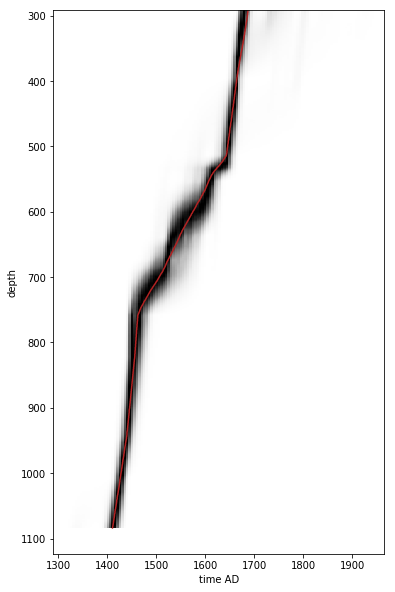

In [73]:
# plot this output
fig, ax = plt.subplots(figsize = (10,10))

# set up the extent
ext = [time_domain.min(),time_domain.max(),z_domain.max(),z_domain.min()]

# aspect ratio of 1:1, can be changed in the set aspect
ar = np.round((ext[1]-ext[0])/(ext[3]-ext[2]))

# plot as 'raster'
ax.imshow((age_z_reg.T),cmap='Greys',origin = 'upper',extent = ext)

# plot the median age as line to check that we have made mistake so far
ax.plot(data[1],data[0],color = "firebrick")

ax.set_aspect(4/3)
ax.set_xlabel('time AD')
ax.set_ylabel('depth')

What this plot answers is the question: at a certain depth, we have an age distribution. We want to answer the converse question, which is, given a certain age, what is the proxy distribution?

Let's say some proxy is measured at random depths of the age model, then, the probability that the measured proxy falls within a range of ages is given by integrating the PDF between the age-boundaries, at one depth slice.

In this Oxcal output model, each 'pixel' at age `a` represents a 5 year slice of the PDF, therefore, approximates the probability that at that depth, the proxy has an age between `a` and `a+5`. For this to work, the sum of all PDF value must be one. This is not the case at present, so we normalize the array.

In [74]:
# the current sum along depth slices does not equal 1
age_z_reg.sum(axis=0)

array([6.166812  , 6.17594012, 6.18506824, ..., 4.65212831, 4.63446369,
       4.61570148])

In [75]:
from sklearn.preprocessing import normalize

In [77]:
# now we normalise (make it sum to 1, which is called an L1 normalisation)
age_z_norm =normalize(age_z_reg,axis=0,norm='l1')

# now the sum along depth slices does equal 1
age_z_norm.sum(axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

Formally, each entry in the age_z_norm array corresponds to $P(a_i<X<a_i+5|z = z_j)$

For instance, the probability that a proxy measured at depth z = 800, has an age between 1450 AD and 1455 AD is given by:


In [85]:
z800 = np.abs(z_domain-800).argmin()
age1450 = np.abs(time_domain-1450).argmin()

print("index in uniform time domain: {}\nindex in uniform depth domain: {}".format(age1450,z800))
print("probability: {:.3f}".format(age_z_norm[age1450,z800]))

index in uniform time domain: 32
index in uniform depth domain: 1007
probability: 0.171


### Working with the proxy data

First we'll import the proxy data measured in the ice cave. At several depths, d18O and d2H are measured.

In [87]:
proxy = pd.read_csv("sample_data/Iglu_sequence_isotopes.csv")

In [93]:
proxy.head()

,d18O,s.d. d18O,d2H,s.d. d2H,depth
0,-11.017767,0.048233,-79.193984,0.547005,1095
1,NaN,NaN,NaN,NaN,1085
2,-9.701445,0.094254,-69.575175,0.557314,1077
3,-10.913558,0.038475,-78.123501,0.223204,1065
4,NaN,NaN,NaN,NaN,1050


In [99]:
# for now select array slice
iso = proxy.loc[:,['depth','d18O','s.d. d18O']].dropna().to_numpy().astype(float).T

### Visualising proxy vs depth

First, let's quickly plot the proxy values against depth (note the reversed depth axis, deep samples should be older than shallow ones!)

(1105.0, 290.0)

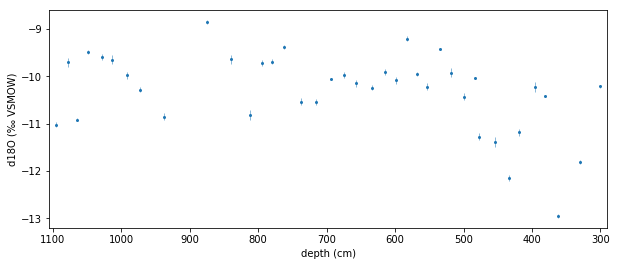

In [116]:
fig, ax = plt.subplots(figsize=(10,4))

# plot the data 
ax.errorbar(iso[0],iso[1],yerr=iso[2],marker='.',markersize=4,elinewidth=0.5,lw=0)
# tidy up axes labels
ax.set_xlabel('depth (cm)')
ax.set_ylabel('d18O (‰ VSMOW)')

# reverse the x-axis
ax.set_xlim(max(iso[0])+10,min(iso[0])-10)

In [115]:
# linear interpolation of proxy data to the depth steps of the age model.

f_iso = interp1d(iso[0],iso[1],kind='linear',bounds_error=False)

iso_interp = f_iso(z_domain)

(1105.0, 290.0)

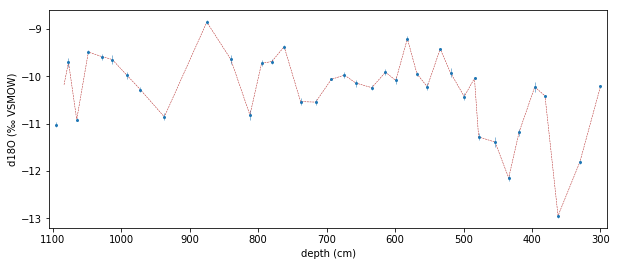

In [119]:
# visualise the linearly interpolated data

fig, ax = plt.subplots(figsize=(10,4))

# plot the data 
ax.errorbar(iso[0],iso[1],yerr=iso[2],marker='.',markersize=4,elinewidth=0.5,lw=0)

# plot the interpolated data
ax.plot(z_domain,iso_interp,ls='--',color = 'firebrick',lw=0.5)

# tidy up axes labels
ax.set_xlabel('depth (cm)')
ax.set_ylabel('d18O (‰ VSMOW)')

# reverse the x-axis
ax.set_xlim(max(iso[0])+10,min(iso[0])-10)

### Gaussian kernel estimation over age slices

For each age slice of the age-depth model, we may estimate a distribution of proxy data with gaussian kernel density estimation.

In [134]:
from scipy.stats import gaussian_kde

In [161]:
# start with a random age slice - say again, age 1450-1455 AD (which we now now is index 32)
weight = age_z_norm[32][np.logical_not(np.isnan(iso_interp))]
proxy  = iso_interp[np.logical_not(np.isnan(iso_interp))]

kde = gaussian_kde(proxy,weights=weight)

dist = kde.evaluate(np.linspace(-15,-6,200))

Text(0.5,1,'proxy PDF at 1450-1455 AD')

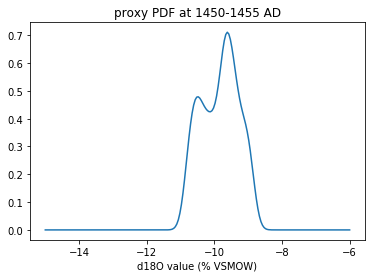

In [204]:
# visualise the data
fig,ax = plt.subplots()

ax.plot(np.linspace(-15,-6,200),dist)

ax.set_xlabel("d18O value (% VSMOW)")
ax.set_title("proxy PDF at 1450-1455 AD")

In [180]:
# Define a function to return the KDE distribution for a specific age_index

def fit(age_index,domain):
    '''
    takes an index in the time domain, returns array of PDF of proxy values
    for that age index
    '''
    weight = age_z_norm[age_index][np.logical_not(np.isnan(iso_interp))]
    proxy  = iso_interp[np.logical_not(np.isnan(iso_interp))]
    try:
        kde = gaussian_kde(proxy,weights=weight)
        dist = kde.evaluate(domain)
        return dist
    except:
        print('all weights were 0, no KDE returned')
        

SyntaxError: 'continue' not properly in loop (<ipython-input-180-38cf320cc24b>, line 15)

In [181]:
# define the proxy domain
proxy_domain = np.linspace(-15,-6,200)

# make empty array container
iso_kde = np.zeros((len(time_domain),len(proxy_domain)))

# loop over each time step and replace zeros, with KDE distribution
for i in range(len(time_domain)):
    iso_kde[i] = fit(i,proxy_domain)

/Users/AchilleTalon/miniconda3/lib/python3.6/site-packages/scipy/stats/kde.py:199: RuntimeWarning: invalid value encountered in true_divide
  self._weights /= sum(self._weights)


all weights were 0, no KDE returned
all weights were 0, no KDE returned
all weights were 0, no KDE returned
all weights were 0, no KDE returned
all weights were 0, no KDE returned


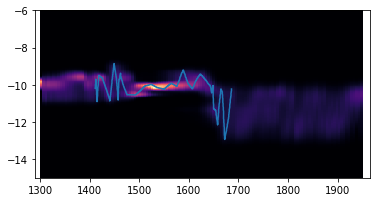

In [203]:
# visualise this data
fig,ax = plt.subplots()

# set up the extent
ext = [time_domain.min(),time_domain.max(),proxy_domain.min(),proxy_domain.max()]

# aspect ratio of 1:1, can be changed in the set aspect
ar = np.round((ext[1]-ext[0])/(ext[3]-ext[2]))
ax.imshow(iso_kde.T, extent = ext,cmap = 'magma',origin='lower')


# plot the isotope values on median age as dummy check.
naive = []
for depth,val in zip(z_domain,iso_interp):
    depth_idx = np.abs(data[0]-depth).argmin()
    
    med_age = data[1][depth_idx]
    naive.append([med_age,val]) 
    
naive = np.array(naive).T

ax.plot(naive[0],naive[1])
ax.set_aspect(ar/2)

It's not looking too bad is it? But a more formal treatment of the whole probabilities is still incoming.

What we really want to know is the probability of an isotope (proxy) value `i`, given an age (or age range) `j`.

$P(\delta^{18}O_i |a_j)$

Bayes' Theorem tells us:


$$P(\delta^{18}O_i |a_j) = \frac{P(a_j|\delta^{18}O_i)\times P(\delta^{18}O_i))}{P(a_j)}$$

Furthermore, the term: $P(a_j|\delta^{18}O_i)$ denotes the probability that a = j, given that the proxy value is j.
This can also be expressed as a conditional probability.

$$P(a_j|\delta^{18}O_i)= \frac{P(a_j\cap \delta^{18}O_i)}{P(\delta^{18}O_i)}$$

But the probability of the intersection $a=j$ and $\delta^{18}O = i$ can be expressed in terms of depth, where n are all the different values a depth can take.

$$P(a_j \cap \delta^{18}O_i) = \sum_{k=0}^{n}P(a_j|z_k)\times P(z_k|\delta^{18}O_i)$$


We multiply the probability of an age (a_i) given a depth (z_k) and a depth (z_k) given a d18O value (d18O_i).

Finally, one more use of Bayes' theorem yields:

$$P(z_k|\delta^{18}O_i) = \frac{P(\delta^{18}O_i|z_k)\times P(z_k)}{P(\delta^{18}O_i)}$$



Finally, by substituting:

$$P(\delta^{18}O_i |a_j) = \frac{\sum_{k=0}^{n}P(a_j|z_k)\times P(\delta^{18}O_i|z_k)\times P(z_k)}{P(\delta^{18}O_i)\times P(a_j)}$$



$P(a_j|z_k)$ is the PDF calculated by Oxcal output, ie: the age-model function.

$P(\delta^{18}O_i|z_k)$ is a probability density function for the measurement and its error (a Normal distribution). It can be approximated by:
$$P(\delta^{18}O_i|z_k) \thicksim \mathcal{N}(\mu_{O_k},\sigma_{O_k}^2)$$

$P(z_k)$ is a uniform distribution of depth. Given a depth increment $\epsilon_1$, 
$$P(z_k) = P(k-0.5\epsilon_1<z<k+0.5\epsilon_1) = \frac{\epsilon_1}{(z_{max}-z_{min})}$$

Likewise, $P(a_j)$ is a uniform distribution of ages. Given an age increment of $\epsilon_2$
$$P(a_j) = P(i-0.5\epsilon_2<a<i+0.5\epsilon_2) = \frac{\epsilon_2}{(a_{max}-a_{min})}$$

Finally, $P(\delta^{18}O_i)$ should be estimated for the whole dataset.

It reflects the underlying distribution of possible $\delta^{18}O$ values. 

It's all nice, but now, it has to be programmed and compared to the naive approach above.